Last updated on March 3, 2025

# Using `barotropic_qglat_lwa` to compute equivalent latitude and local wave activity (total, cyclonic and anticyclonic)

## Instructions

This sample code demonstrate how the wrapper function "barotropic_eqlat_lwa" in thepython package "hn2016_falwa" computes the finite-amplitude local wave activity 
(LWA) from absolute vorticity fields in a barotropic model with spherical geometry according to the definition in Huang & Nakamura (2016,JAS) equation (13). This 
sample code reproduces the LWA plots (Fig.4 in HN15) computed based on an absolute vorticity map.

## Contact

Please make inquiries and report issues via Github: https://github.com/csyhuang/hn2016_falwa/issues

In [5]:
from falwa.wrapper import barotropic_eqlat_lwa # Module for plotting local wave activity (LWA) plots and 
                        # the corresponding equivalent-latitude profile
from math import pi
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# --- Parameters --- #
Earth_radius = 6.378e+6 # Earth's radius

# --- Load the absolute vorticity field [256x512] --- #
readFile = xr.open_dataset('barotropic_vorticity.nc')


# --- Read in longitude and latitude arrays --- #
xlon = readFile.longitude.values
ylat = readFile.latitude.values
clat = np.abs(np.cos(ylat*pi/180.)) # cosine latitude
nlon = xlon.size
nlat = ylat.size

# --- Parameters needed to use the module HN2015_LWA --- #
dphi = (ylat[2]-ylat[1])*pi/180. # Equal spacing between latitude grid points, in radian
area = 2.*pi*Earth_radius**2 *(np.cos(ylat[:,np.newaxis]*pi/180.)*dphi)/float(nlon) * np.ones((nlat,nlon))
area = np.abs(area) # To make sure area element is always positive (given floating point errors). 

# --- Read in the absolute vorticity field from the netCDF file --- #
absVorticity = readFile.absolute_vorticity.values



## Obtain equivalent-latitude relationship and also the LWA from an absolute vorticity snapshot

In [6]:
# --- Obtain equivalent-latitude relationship and also the LWA from the absolute vorticity snapshot ---
qref, lwa = barotropic_eqlat_lwa(ylat,absVorticity,area,Earth_radius*clat*dphi,nlat) # Full domain included

## Plotting the results

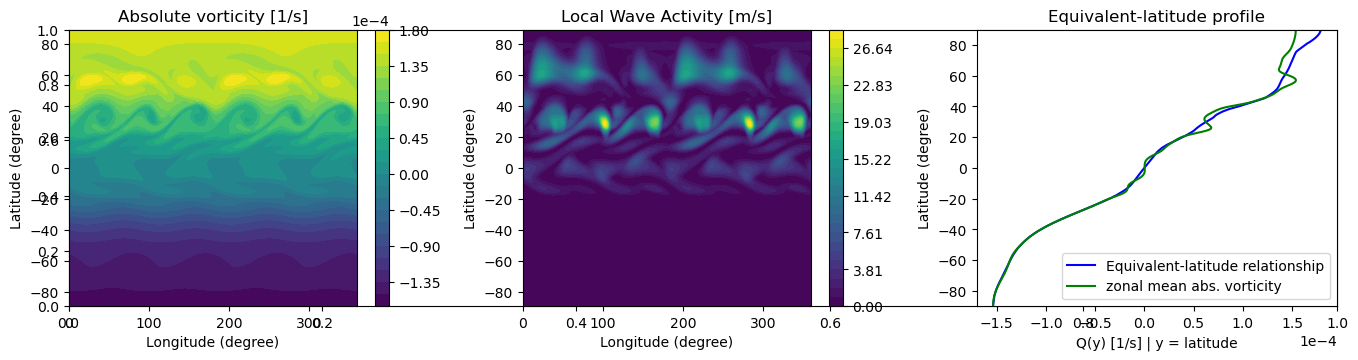

In [7]:
# --- Color axis for plotting LWA --- #
lwa_caxis = np.linspace(0,lwa.max(),31,endpoint=True)

# --- Plot the abs. vorticity field, LWA and equivalent-latitude relationship and LWA --- #
fig = plt.subplots(figsize=(14,4))

plt.subplot(1,3,1) # Absolute vorticity map
c=plt.contourf(xlon,ylat,absVorticity,31)
cb = plt.colorbar(c)     
cb.formatter.set_powerlimits((0, 0))
cb.ax.yaxis.set_offset_position('right')                         
cb.update_ticks()
plt.title('Absolute vorticity [1/s]')
plt.xlabel('Longitude (degree)')
plt.ylabel('Latitude (degree)')

plt.subplot(1,3,2) # LWA (full domain)
plt.contourf(xlon,ylat,lwa,lwa_caxis)
plt.colorbar()
plt.title('Local Wave Activity [m/s]')
plt.xlabel('Longitude (degree)')
plt.ylabel('Latitude (degree)')

plt.subplot(1,3,3) # Equivalent-latitude relationship Q(y)
plt.plot(qref, ylat, 'b', label='Equivalent-latitude relationship')
plt.plot(np.mean(absVorticity,axis=1),ylat,'g',label='zonal mean abs. vorticity')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylim(-90,90)
plt.legend(loc=4,fontsize=10)
plt.title('Equivalent-latitude profile')
plt.ylabel('Latitude (degree)')
plt.xlabel('Q(y) [1/s] | y = latitude')
plt.tight_layout()
plt.show()


## Compute local wave activity partitioned into anticyclonic and cyclonic components

This can be done by setting the input parameter `return_partitioned_lwa=True`

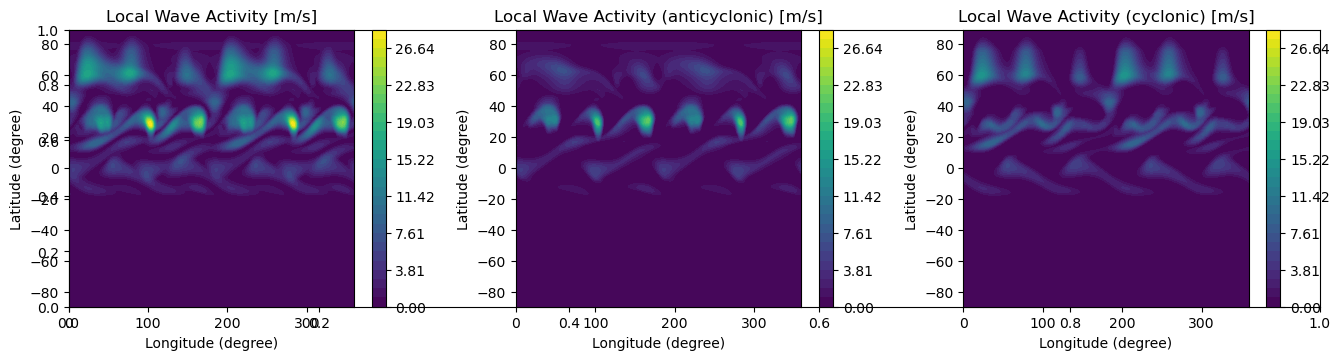

In [8]:
qref, lwa = barotropic_eqlat_lwa(ylat,absVorticity,area,Earth_radius*clat*dphi,nlat, return_partitioned_lwa=True) # Full domain included

fig = plt.subplots(figsize=(14,4))
plt.subplot(1,3,1) # LWA (full domain)
plt.contourf(xlon,ylat,lwa.sum(axis=0),lwa_caxis)
plt.colorbar()
plt.title('Local Wave Activity [m/s]')
plt.xlabel('Longitude (degree)')
plt.ylabel('Latitude (degree)')

plt.subplot(1,3,2) # LWA (full domain)
plt.contourf(xlon,ylat,lwa[0, :, :],lwa_caxis)
plt.colorbar()
plt.title('Local Wave Activity (anticyclonic) [m/s]')
plt.xlabel('Longitude (degree)')
plt.ylabel('Latitude (degree)')

plt.subplot(1,3,3) # LWA (full domain)
plt.contourf(xlon,ylat,lwa[1, :, :],lwa_caxis)
plt.colorbar()
plt.title('Local Wave Activity (cyclonic) [m/s]')
plt.xlabel('Longitude (degree)')
plt.ylabel('Latitude (degree)')
plt.tight_layout()
plt.show()